## Multi-task recommenders

In [1]:
from typing import Dict, Text
from firebase import firebase

import os
import pprint
import tempfile
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_recommenders as tfrs

### Preparing the dataset

In [2]:
firebase = firebase.FirebaseApplication('firebase-key', None)
firebase_ratings = firebase.get('/User_Book', None)
firebase_books = firebase.get('/Books', None)

In [3]:
ratings_df = pd.DataFrame.from_dict(firebase_ratings, orient='index')
books_df = pd.DataFrame.from_dict(firebase_books, orient='index')

In [4]:
ratings_df.head()

,bookId,isbn,myRate,userId
-NWcEFgMwmdaYc-4ndml,-NWcEFeoVaEgjMwiboCA,09781565841000,5.0,3avc3TUJioP8XGD0bLK9xtV7uIG3
-NWcEGniRUJ0hRQmvclo,-NWcEGmQeH3eiHRZ0w7G,09781929610259,4.5,3avc3TUJioP8XGD0bLK9xtV7uIG3
-NWcEHtzsgGbN7rpUZ6V,-NWcEHsFfJ3yqXud1NGo,09780814326114,4.0,3avc3TUJioP8XGD0bLK9xtV7uIG3
-NWcEJunG4PfX-aAVxiF,-NWcEJqjxIyMQv5izHrS,09780312010447,4.5,3avc3TUJioP8XGD0bLK9xtV7uIG3
-NWcELFol68JZpsfvkyF,-NWcELEEV0QR6EHobxIe,09780143036357,3.5,3avc3TUJioP8XGD0bLK9xtV7uIG3


In [5]:
len(set(books_df["isbn"]))

685

In [6]:
books_df.tail()

,author,description,documentId,genre,image,isbn,myRate,pages,publishedYear,rating,title
-NWrg1OflLQlil9mKiuy,Jeff Smith,Jeff Smith teaches surefire techniques for ach...,,Photography,https://books.google.com/books/content?id=CzPB...,09781584281344,4.5,124,2004,3.38,Posing for Portrait Photography
-NWrg20FAIQTRTREU-MD,Bill Watterson,Compiles a selection of Sunday cartoons select...,,Comics & Graphic Novels,https://books.google.com/books/content?id=3-7l...,09780740721359,3.0,96,2001,4.71,Calvin and Hobbes: Sunday Pages 1985-1995
-NWrg2aMFx1-xxxXi3rP,Bill Watterson,"Brings together every ""Calvin and Hobbes"" cart...",,Comics & Graphic Novels,https://books.google.com/books/content?id=wmjG...,09780740748479,5.0,1456,2005,4.82,The Complete Calvin and Hobbes
-NWrg39wcp-4N9uuBQd0,Douglas Downing,"Covers the fundamentals of algebra, including ...",,Mathematics,https://books.google.com/books/content?id=RiX-...,09780764119729,1.0,392,2003,4.06,Algebra the Easy Way
-NZQys_bpJaiFODRIKHS,John Lewis Gaddis,"A classic synthesis of US security policy, now...",,History,https://books.google.com/books/content?id=HVsS...,09780195174472,NaN,484,2005,4.01,Strategies of Containment


In [7]:
len(books_df)

979

In [8]:
#drop manually added books
books_df = books_df[books_df['rating'] != '']

In [9]:
len(books_df)

979

In [10]:
books_df = pd.DataFrame(set(books_df["isbn"]),columns=["isbn"])

In [11]:
books_df

,isbn
0,09781859843987
1,09780743264730
2,09780679785897
3,09780140285970
4,09780811205467
...,...
680,09780006479673
681,09780141182582
682,09780099409960
683,09780822000235


In [12]:
#transforms dataframes in datasets with tensor
ratings_dataset = tf.data.Dataset.from_tensor_slices(dict(ratings_df))
books_dataset = tf.data.Dataset.from_tensor_slices(dict(books_df))

In [13]:
ratings = ratings_dataset.map(lambda x: {
    "book_isbn": x["isbn"],
    "user_id": x["userId"],
    "user_rating": x["myRate"],
})
books = books_dataset.map(lambda x: x["isbn"])

In [14]:
ratings

<_MapDataset element_spec={'book_isbn': TensorSpec(shape=(), dtype=tf.string, name=None), 'user_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'user_rating': TensorSpec(shape=(), dtype=tf.float64, name=None)}>

In [15]:
books

<_MapDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [16]:
len(books)

685

In [17]:
len(ratings)

979

In [18]:
# Randomly shuffle data and split between train and test.
tf.random.set_seed(42)
shuffled = ratings.shuffle(len(ratings_df), seed=42, reshuffle_each_iteration=False)

train = shuffled.take(800)
test = shuffled.skip(800).take(210)

book_isbns = books.batch(25) #100 50
user_ids = ratings.batch(10_000).map(lambda x: x["user_id"])

unique_book_isbns = np.unique(np.concatenate(list(book_isbns)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

## A multi-task model

In [19]:
class BookModel(tfrs.models.Model):

    def __init__(self, rating_weight: float, retrieval_weight: float) -> None:
        super().__init__()

        embedding_dimension = 64 #32

        # User and book models.
        self.book_model: tf.keras.layers.Layer = tf.keras.Sequential([
          tf.keras.layers.StringLookup(
            vocabulary=unique_book_isbns, mask_token=None),
          tf.keras.layers.Embedding(len(unique_book_isbns) + 1, embedding_dimension)
        ])
        self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
          tf.keras.layers.StringLookup(
            vocabulary=unique_user_ids, mask_token=None),
          tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
        ])

        # Rating model
        self.rating_model = tf.keras.Sequential([
            tf.keras.layers.Dense(512, activation="relu"),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(32, activation="relu"),
            tf.keras.layers.Dense(1),
        ])

        # The tasks.
        self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()],
        )
        self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=books.batch(16).map(self.book_model) #128 32
            )
        )

        # The loss weights.
        self.rating_weight = rating_weight
        self.retrieval_weight = retrieval_weight

    def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
       
        user_embeddings = self.user_model(features["user_id"])
       
        book_embeddings = self.book_model(features["book_isbn"])

        return (
            user_embeddings,
            book_embeddings,
            # We apply the multi-layered rating model to a concatentation of
            # user and book embeddings.
            self.rating_model(
                tf.concat([user_embeddings, book_embeddings], axis=1)
            ),
        )

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:

        ratings = features.pop("user_rating")

        user_embeddings, book_embeddings, rating_predictions = self(features)

        # We compute the loss for each task.
        rating_loss = self.rating_task(
            labels=ratings,
            predictions=rating_predictions,
        )
        retrieval_loss = self.retrieval_task(user_embeddings, book_embeddings)
        # And combine them using the loss weights.
        return (self.rating_weight * rating_loss
                + self.retrieval_weight * retrieval_loss)

## Rating-specialized model

In [20]:
model = BookModel(rating_weight=1.0, retrieval_weight=0.0)
model.compile(optimizer=tf.keras.optimizers.AdamW(0.005))

In [21]:
tf.random.set_seed(42)
cached_train = train.shuffle(800).batch(32).cache() #128 64
cached_test = test.batch(16).cache() #64 32

In [22]:
history_rating_model = model.fit(cached_train, epochs= 100)
metrics = model.evaluate(cached_test, return_dict=True)

print(f"Retrieval top-10 accuracy: {metrics['factorized_top_k/top_10_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

Epoch 1/100
25/25 [==============================] - 6s 65ms/step - root_mean_squared_error: 2.1195 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0025 - factorized_top_k/top_10_categorical_accuracy: 0.0075 - factorized_top_k/top_50_categorical_accuracy: 0.0562 - factorized_top_k/top_100_categorical_accuracy: 0.1350 - loss: 4.3985 - regularization_loss: 0.0000e+00 - total_loss: 4.3985
Epoch 2/100
25/25 [==============================] - 2s 65ms/step - root_mean_squared_error: 1.2770 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0088 - factorized_top_k/top_10_categorical_accuracy: 0.0213 - factorized_top_k/top_50_categorical_accuracy: 0.0975 - factorized_top_k/top_100_categorical_accuracy: 0.1663 - loss: 1.6485 - regularization_loss: 0.0000e+00 - total_loss: 1.6485
Epoch 3/100
25/25 [==============================] - 2s 64ms/step - root_mean_squared_error: 1.4550 - fa

25/25 [==============================] - 2s 77ms/step - root_mean_squared_error: 0.3620 - factorized_top_k/top_1_categorical_accuracy: 0.0012 - factorized_top_k/top_5_categorical_accuracy: 0.0075 - factorized_top_k/top_10_categorical_accuracy: 0.0162 - factorized_top_k/top_50_categorical_accuracy: 0.0775 - factorized_top_k/top_100_categorical_accuracy: 0.1675 - loss: 0.1311 - regularization_loss: 0.0000e+00 - total_loss: 0.1311
Epoch 20/100
25/25 [==============================] - 2s 74ms/step - root_mean_squared_error: 0.3446 - factorized_top_k/top_1_categorical_accuracy: 0.0012 - factorized_top_k/top_5_categorical_accuracy: 0.0088 - factorized_top_k/top_10_categorical_accuracy: 0.0150 - factorized_top_k/top_50_categorical_accuracy: 0.0737 - factorized_top_k/top_100_categorical_accuracy: 0.1700 - loss: 0.1162 - regularization_loss: 0.0000e+00 - total_loss: 0.1162
Epoch 21/100
25/25 [==============================] - 2s 76ms/step - root_mean_squared_error: 0.4137 - factorized_top_k/top

25/25 [==============================] - 2s 74ms/step - root_mean_squared_error: 0.3686 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0063 - factorized_top_k/top_10_categorical_accuracy: 0.0150 - factorized_top_k/top_50_categorical_accuracy: 0.0812 - factorized_top_k/top_100_categorical_accuracy: 0.1825 - loss: 0.1400 - regularization_loss: 0.0000e+00 - total_loss: 0.1400
Epoch 38/100
25/25 [==============================] - 2s 74ms/step - root_mean_squared_error: 0.3595 - factorized_top_k/top_1_categorical_accuracy: 0.0012 - factorized_top_k/top_5_categorical_accuracy: 0.0088 - factorized_top_k/top_10_categorical_accuracy: 0.0175 - factorized_top_k/top_50_categorical_accuracy: 0.0812 - factorized_top_k/top_100_categorical_accuracy: 0.1750 - loss: 0.1275 - regularization_loss: 0.0000e+00 - total_loss: 0.1275
Epoch 39/100
25/25 [==============================] - 2s 74ms/step - root_mean_squared_error: 0.3824 - factorized_top_k

25/25 [==============================] - 2s 72ms/step - root_mean_squared_error: 0.1315 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0037 - factorized_top_k/top_10_categorical_accuracy: 0.0162 - factorized_top_k/top_50_categorical_accuracy: 0.0775 - factorized_top_k/top_100_categorical_accuracy: 0.1700 - loss: 0.0169 - regularization_loss: 0.0000e+00 - total_loss: 0.0169
Epoch 56/100
25/25 [==============================] - 2s 72ms/step - root_mean_squared_error: 0.1408 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0037 - factorized_top_k/top_10_categorical_accuracy: 0.0150 - factorized_top_k/top_50_categorical_accuracy: 0.0750 - factorized_top_k/top_100_categorical_accuracy: 0.1675 - loss: 0.0196 - regularization_loss: 0.0000e+00 - total_loss: 0.0196
Epoch 57/100
25/25 [==============================] - 2s 74ms/step - root_mean_squared_error: 0.1436 - factorized_t

25/25 [==============================] - 2s 77ms/step - root_mean_squared_error: 0.2810 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0025 - factorized_top_k/top_10_categorical_accuracy: 0.0125 - factorized_top_k/top_50_categorical_accuracy: 0.0900 - factorized_top_k/top_100_categorical_accuracy: 0.1725 - loss: 0.0801 - regularization_loss: 0.0000e+00 - total_loss: 0.0801
Epoch 74/100
25/25 [==============================] - 2s 75ms/step - root_mean_squared_error: 0.2722 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0025 - factorized_top_k/top_10_categorical_accuracy: 0.0113 - factorized_top_k/top_50_categorical_accuracy: 0.0887 - factorized_top_k/top_100_categorical_accuracy: 0.1800 - loss: 0.0723 - regularization_loss: 0.0000e+00 - total_loss: 0.0723
Epoch 75/100
25/25 [==============================] - 2s 76ms/step - root_mean_squared_error: 0.2949 - factorized_t

25/25 [==============================] - 2s 69ms/step - root_mean_squared_error: 0.1315 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0063 - factorized_top_k/top_10_categorical_accuracy: 0.0188 - factorized_top_k/top_50_categorical_accuracy: 0.0862 - factorized_top_k/top_100_categorical_accuracy: 0.1713 - loss: 0.0174 - regularization_loss: 0.0000e+00 - total_loss: 0.0174
Epoch 92/100
25/25 [==============================] - 2s 76ms/step - root_mean_squared_error: 0.1181 - factorized_top_k/top_1_categorical_accuracy: 0.0012 - factorized_top_k/top_5_categorical_accuracy: 0.0075 - factorized_top_k/top_10_categorical_accuracy: 0.0188 - factorized_top_k/top_50_categorical_accuracy: 0.0862 - factorized_top_k/top_100_categorical_accuracy: 0.1750 - loss: 0.0142 - regularization_loss: 0.0000e+00 - total_loss: 0.0142
Epoch 93/100
25/25 [==============================] - 2s 67ms/step - root_mean_squared_error: 0.1153 - factorized_top_k

## Retrieval-specialized model

In [23]:
model = BookModel(rating_weight=0.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.AdamW(0.005))

In [24]:
history_retrieval_model = model.fit(cached_train, epochs= 100)
metrics = model.evaluate(cached_test, return_dict=True)

print(f"Retrieval top-10 accuracy: {metrics['factorized_top_k/top_10_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

Epoch 1/100
25/25 [==============================] - 4s 67ms/step - root_mean_squared_error: 3.7465 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0025 - factorized_top_k/top_10_categorical_accuracy: 0.0100 - factorized_top_k/top_50_categorical_accuracy: 0.0700 - factorized_top_k/top_100_categorical_accuracy: 0.1513 - loss: 110.9072 - regularization_loss: 0.0000e+00 - total_loss: 110.9072
Epoch 2/100
25/25 [==============================] - 2s 69ms/step - root_mean_squared_error: 3.7547 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.3237 - factorized_top_k/top_10_categorical_accuracy: 0.8825 - factorized_top_k/top_50_categorical_accuracy: 0.9937 - factorized_top_k/top_100_categorical_accuracy: 0.9962 - loss: 108.4742 - regularization_loss: 0.0000e+00 - total_loss: 108.4742
Epoch 3/100
25/25 [==============================] - 2s 66ms/step - root_mean_squared_error: 3.7

25/25 [==============================] - 2s 67ms/step - root_mean_squared_error: 3.9405 - factorized_top_k/top_1_categorical_accuracy: 0.0050 - factorized_top_k/top_5_categorical_accuracy: 0.5238 - factorized_top_k/top_10_categorical_accuracy: 0.9812 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 8.9562 - regularization_loss: 0.0000e+00 - total_loss: 8.9562
Epoch 20/100
25/25 [==============================] - 2s 79ms/step - root_mean_squared_error: 3.9414 - factorized_top_k/top_1_categorical_accuracy: 0.0063 - factorized_top_k/top_5_categorical_accuracy: 0.5275 - factorized_top_k/top_10_categorical_accuracy: 0.9825 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 8.8759 - regularization_loss: 0.0000e+00 - total_loss: 8.8759
Epoch 21/100
25/25 [==============================] - 2s 66ms/step - root_mean_squared_error: 3.9423 - factorized_top_k/top

25/25 [==============================] - 2s 73ms/step - root_mean_squared_error: 3.9458 - factorized_top_k/top_1_categorical_accuracy: 0.0063 - factorized_top_k/top_5_categorical_accuracy: 0.5300 - factorized_top_k/top_10_categorical_accuracy: 0.9812 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 8.3112 - regularization_loss: 0.0000e+00 - total_loss: 8.3112
Epoch 38/100
25/25 [==============================] - 6s 246ms/step - root_mean_squared_error: 3.9456 - factorized_top_k/top_1_categorical_accuracy: 0.0063 - factorized_top_k/top_5_categorical_accuracy: 0.5312 - factorized_top_k/top_10_categorical_accuracy: 0.9825 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 8.2883 - regularization_loss: 0.0000e+00 - total_loss: 8.2883
Epoch 39/100
25/25 [==============================] - 2s 97ms/step - root_mean_squared_error: 3.9455 - factorized_top_k/to

25/25 [==============================] - 2s 78ms/step - root_mean_squared_error: 3.9413 - factorized_top_k/top_1_categorical_accuracy: 0.0088 - factorized_top_k/top_5_categorical_accuracy: 0.5387 - factorized_top_k/top_10_categorical_accuracy: 0.9825 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 8.1251 - regularization_loss: 0.0000e+00 - total_loss: 8.1251
Epoch 56/100
25/25 [==============================] - 2s 83ms/step - root_mean_squared_error: 3.9409 - factorized_top_k/top_1_categorical_accuracy: 0.0063 - factorized_top_k/top_5_categorical_accuracy: 0.5437 - factorized_top_k/top_10_categorical_accuracy: 0.9825 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 8.1152 - regularization_loss: 0.0000e+00 - total_loss: 8.1152
Epoch 57/100
25/25 [==============================] - 2s 80ms/step - root_mean_squared_error: 3.9406 - factorized_top_k/top

25/25 [==============================] - 2s 87ms/step - root_mean_squared_error: 3.9341 - factorized_top_k/top_1_categorical_accuracy: 0.0100 - factorized_top_k/top_5_categorical_accuracy: 0.5400 - factorized_top_k/top_10_categorical_accuracy: 0.9837 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 8.0349 - regularization_loss: 0.0000e+00 - total_loss: 8.0349
Epoch 74/100
25/25 [==============================] - 2s 69ms/step - root_mean_squared_error: 3.9336 - factorized_top_k/top_1_categorical_accuracy: 0.0063 - factorized_top_k/top_5_categorical_accuracy: 0.5375 - factorized_top_k/top_10_categorical_accuracy: 0.9812 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 8.0372 - regularization_loss: 0.0000e+00 - total_loss: 8.0372
Epoch 75/100
25/25 [==============================] - 2s 68ms/step - root_mean_squared_error: 3.9332 - factorized_top_k/top

25/25 [==============================] - 2s 67ms/step - root_mean_squared_error: 3.9261 - factorized_top_k/top_1_categorical_accuracy: 0.0088 - factorized_top_k/top_5_categorical_accuracy: 0.5375 - factorized_top_k/top_10_categorical_accuracy: 0.9812 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 7.9741 - regularization_loss: 0.0000e+00 - total_loss: 7.9741
Epoch 92/100
25/25 [==============================] - 3s 113ms/step - root_mean_squared_error: 3.9257 - factorized_top_k/top_1_categorical_accuracy: 0.0063 - factorized_top_k/top_5_categorical_accuracy: 0.5412 - factorized_top_k/top_10_categorical_accuracy: 0.9812 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 7.9705 - regularization_loss: 0.0000e+00 - total_loss: 7.9705
Epoch 93/100
25/25 [==============================] - 2s 99ms/step - root_mean_squared_error: 3.9252 - factorized_top_k/to

### Joint model

In [25]:
tf.random.set_seed(42)
model = BookModel(rating_weight=1.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.AdamW(0.005))

In [26]:
tf.random.set_seed(42)
history_joint_model = model.fit(cached_train, epochs= 100)
metrics = model.evaluate(cached_test, return_dict=True)

print(f"Retrieval top-10 accuracy: {metrics['factorized_top_k/top_10_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

Epoch 1/100
25/25 [==============================] - 5s 83ms/step - root_mean_squared_error: 1.8765 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0075 - factorized_top_k/top_10_categorical_accuracy: 0.0125 - factorized_top_k/top_50_categorical_accuracy: 0.0775 - factorized_top_k/top_100_categorical_accuracy: 0.1475 - loss: 114.3866 - regularization_loss: 0.0000e+00 - total_loss: 114.3866
Epoch 2/100
25/25 [==============================] - 2s 85ms/step - root_mean_squared_error: 1.1447 - factorized_top_k/top_1_categorical_accuracy: 0.0050 - factorized_top_k/top_5_categorical_accuracy: 0.2475 - factorized_top_k/top_10_categorical_accuracy: 0.4000 - factorized_top_k/top_50_categorical_accuracy: 0.6712 - factorized_top_k/top_100_categorical_accuracy: 0.7675 - loss: 111.1875 - regularization_loss: 0.0000e+00 - total_loss: 111.1875
Epoch 3/100
25/25 [==============================] - 2s 83ms/step - root_mean_squared_error: 0.8655 

25/25 [==============================] - 2s 82ms/step - root_mean_squared_error: 0.3881 - factorized_top_k/top_1_categorical_accuracy: 0.0063 - factorized_top_k/top_5_categorical_accuracy: 0.5163 - factorized_top_k/top_10_categorical_accuracy: 0.9825 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 9.5468 - regularization_loss: 0.0000e+00 - total_loss: 9.5468
Epoch 20/100
25/25 [==============================] - 2s 81ms/step - root_mean_squared_error: 0.4403 - factorized_top_k/top_1_categorical_accuracy: 0.0100 - factorized_top_k/top_5_categorical_accuracy: 0.5138 - factorized_top_k/top_10_categorical_accuracy: 0.9825 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 9.5035 - regularization_loss: 0.0000e+00 - total_loss: 9.5035
Epoch 21/100
25/25 [==============================] - 2s 82ms/step - root_mean_squared_error: 0.4575 - factorized_top_k/top

25/25 [==============================] - 2s 80ms/step - root_mean_squared_error: 0.7575 - factorized_top_k/top_1_categorical_accuracy: 0.0125 - factorized_top_k/top_5_categorical_accuracy: 0.5487 - factorized_top_k/top_10_categorical_accuracy: 0.9825 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 9.0000 - regularization_loss: 0.0000e+00 - total_loss: 9.0000
Epoch 38/100
25/25 [==============================] - 2s 79ms/step - root_mean_squared_error: 0.9486 - factorized_top_k/top_1_categorical_accuracy: 0.0213 - factorized_top_k/top_5_categorical_accuracy: 0.5437 - factorized_top_k/top_10_categorical_accuracy: 0.9825 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 9.2831 - regularization_loss: 0.0000e+00 - total_loss: 9.2831
Epoch 39/100
25/25 [==============================] - 2s 83ms/step - root_mean_squared_error: 0.8444 - factorized_top_k/top

25/25 [==============================] - 2s 69ms/step - root_mean_squared_error: 0.2237 - factorized_top_k/top_1_categorical_accuracy: 0.0088 - factorized_top_k/top_5_categorical_accuracy: 0.5412 - factorized_top_k/top_10_categorical_accuracy: 0.9825 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 8.2390 - regularization_loss: 0.0000e+00 - total_loss: 8.2390
Epoch 56/100
25/25 [==============================] - 2s 70ms/step - root_mean_squared_error: 0.1953 - factorized_top_k/top_1_categorical_accuracy: 0.0075 - factorized_top_k/top_5_categorical_accuracy: 0.5375 - factorized_top_k/top_10_categorical_accuracy: 0.9825 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 8.2182 - regularization_loss: 0.0000e+00 - total_loss: 8.2182
Epoch 57/100
25/25 [==============================] - 2s 99ms/step - root_mean_squared_error: 0.1676 - factorized_top_k/top

25/25 [==============================] - 2s 68ms/step - root_mean_squared_error: 0.2655 - factorized_top_k/top_1_categorical_accuracy: 0.0175 - factorized_top_k/top_5_categorical_accuracy: 0.5387 - factorized_top_k/top_10_categorical_accuracy: 0.9812 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 8.1057 - regularization_loss: 0.0000e+00 - total_loss: 8.1057
Epoch 74/100
25/25 [==============================] - 2s 68ms/step - root_mean_squared_error: 0.3176 - factorized_top_k/top_1_categorical_accuracy: 0.0100 - factorized_top_k/top_5_categorical_accuracy: 0.5412 - factorized_top_k/top_10_categorical_accuracy: 0.9825 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 8.1415 - regularization_loss: 0.0000e+00 - total_loss: 8.1415
Epoch 75/100
25/25 [==============================] - 2s 69ms/step - root_mean_squared_error: 0.3719 - factorized_top_k/top

25/25 [==============================] - 2s 68ms/step - root_mean_squared_error: 0.2346 - factorized_top_k/top_1_categorical_accuracy: 0.0113 - factorized_top_k/top_5_categorical_accuracy: 0.5387 - factorized_top_k/top_10_categorical_accuracy: 0.9787 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 8.0285 - regularization_loss: 0.0000e+00 - total_loss: 8.0285
Epoch 92/100
25/25 [==============================] - 2s 66ms/step - root_mean_squared_error: 0.2312 - factorized_top_k/top_1_categorical_accuracy: 0.0137 - factorized_top_k/top_5_categorical_accuracy: 0.5425 - factorized_top_k/top_10_categorical_accuracy: 0.9800 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 8.0277 - regularization_loss: 0.0000e+00 - total_loss: 8.0277
Epoch 93/100
25/25 [==============================] - 2s 64ms/step - root_mean_squared_error: 0.2468 - factorized_top_k/top

### DATA

In [27]:
def draw_plot(name, joint, retrieval, rating, loss):
    epochs = range(1, len(joint) + 1)
    
    plt.plot(epochs, joint, 'b', label= name +' Joint')
    plt.plot(epochs, retrieval, 'y', label=name + ' Retrieval')
    plt.plot(epochs, rating, 'g', label=name + ' Rating')
    plt.title(name)
    plt.xlabel('Epochs')
    plt.ylabel(loss)
    plt.legend()
    plt.show()

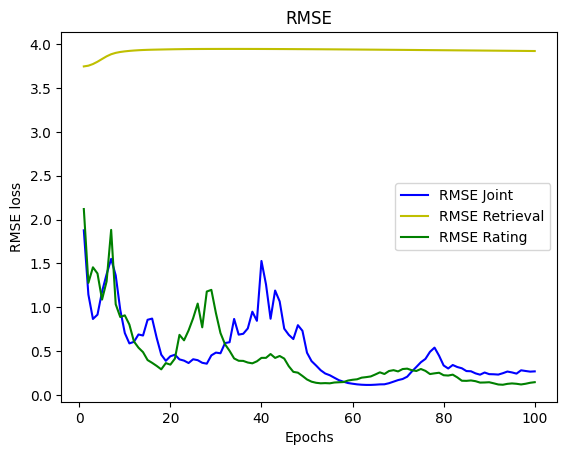

In [28]:
RMSE_joint = history_joint_model.history['root_mean_squared_error']
RMSE_retrieval = history_retrieval_model.history['root_mean_squared_error']
RMSE_rating = history_rating_model.history['root_mean_squared_error']

draw_plot('RMSE', RMSE_joint,RMSE_retrieval,RMSE_rating, "RMSE loss")

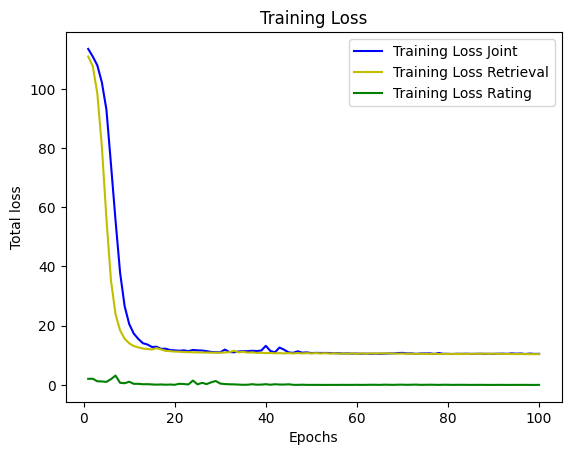

In [29]:
total_loss_values_joint = history_joint_model.history['total_loss']
total_loss_values_retrieval = history_retrieval_model.history['total_loss']
total_loss_values_rating = history_rating_model.history['total_loss']

draw_plot('Training Loss', total_loss_values_joint,total_loss_values_retrieval,total_loss_values_rating, "Total loss")

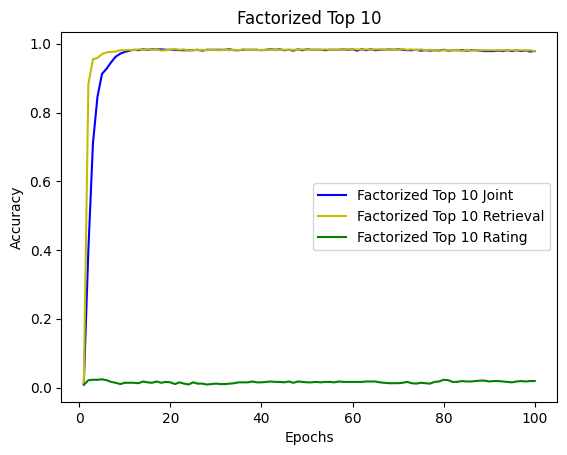

In [30]:
factorized_top10_joint = history_joint_model.history['factorized_top_k/top_10_categorical_accuracy']
factorized_top10_retrieval = history_retrieval_model.history['factorized_top_k/top_10_categorical_accuracy']
factorized_top10_rating = history_rating_model.history['factorized_top_k/top_10_categorical_accuracy']

draw_plot('Factorized Top 10', factorized_top10_joint,factorized_top10_retrieval,factorized_top10_rating, "Accuracy")

## Making predictions

In [31]:
trained_movie_embeddings, trained_user_embeddings, predicted_rating = model({
      "user_id": np.array(["3avc3TUJioP8XGD0bLK9xtV7uIG3"]),
      "book_isbn": np.array(["09781880685358"])
  })
print("Predicted rating:")
print(predicted_rating)

Predicted rating:
tf.Tensor([[0.9783092]], shape=(1, 1), dtype=float32)


In [32]:
user_id = ["3avc3TUJioP8XGD0bLK9xtV7uIG3"]
isbn_list = set(books_df["isbn"])
for isbn in isbn_list:
    trained_movie_embeddings, trained_user_embeddings, predicted_rating = model({
      "user_id": np.array(user_id),
      "book_isbn": np.array([isbn])
    })
    print(predicted_rating)

tf.Tensor([[2.9690425]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.6919734]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.2633033]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.708854]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.7481537]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.929495]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.546031]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.4936101]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.4639418]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.5493696]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.1206744]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.0482447]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9783092]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.061831]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.0269182]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.0424633]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.4546752]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.6955142]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.080707]], shape=(1

tf.Tensor([[1.0129929]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.9516258]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.575077]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9783092]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.3768773]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.1777606]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.090639]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.6912107]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.9400532]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.8605263]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.205397]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.0693517]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.2647321]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.948825]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.0291157]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.683486]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.6634529]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.0583386]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.9378355]], shape=(1

tf.Tensor([[4.1225705]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.1608868]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.6565684]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9783092]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.0100588]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.661673]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9848002]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.219861]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.1118581]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.7632334]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.0572863]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9783092]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.4218674]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.6671801]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.0299606]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9783092]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.3649855]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.5898693]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.322107]], shape=

tf.Tensor([[0.9945689]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.005394]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.014292]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.931569]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.7116151]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.286435]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.6132605]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.0092678]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.8263192]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.4683707]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.0212529]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.4529035]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.5156357]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.136919]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.7474465]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.9592288]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.0145164]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.105706]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.2940159]], shape=(1,

tf.Tensor([[3.1171758]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9783092]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.268966]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.0925336]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.0501275]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.1261153]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9783092]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.189582]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.1418225]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.126363]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.1861796]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.5984144]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9783092]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.7531]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.840119]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.8214173]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.4278512]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.8476354]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.7946208]], shape=(1, 

### Save the model 

In [33]:
model.retrieval_task = tfrs.tasks.Retrieval()  # Removes the metrics.
model.compile()
model.save("final_model")

INFO:tensorflow:Assets written to: final_model\assets


INFO:tensorflow:Assets written to: final_model\assets


In [34]:
# load model
model = tf.keras.models.load_model("final_model")

In [35]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("final_model") # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('final_model.tflite', 'wb') as f:
    f.write(tflite_model)

### Tf Lite

In [36]:
interpreter = tf.lite.Interpreter(model_path="final_model.tflite")
interpreter.allocate_tensors()

#Get input details
input_details = interpreter.get_input_details()
for input_tensor in input_details:
    print("Input name:", input_tensor["name"])
    print("Input shape:", input_tensor["shape"])
    print("Input data type:", input_tensor["dtype"])
    print()
#Get output details
output_details = interpreter.get_output_details()
for output_tensor in output_details:
    print("Output name:", output_tensor["name"])
    print("Output shape:", output_tensor["shape"])
    print("Output data type:", output_tensor["dtype"])
    print()

Input name: serving_default_book_isbn:0
Input shape: [1]
Input data type: <class 'numpy.bytes_'>

Input name: serving_default_user_id:0
Input shape: [1]
Input data type: <class 'numpy.bytes_'>

Output name: StatefulPartitionedCall:0
Output shape: []
Output data type: <class 'numpy.float32'>

Output name: StatefulPartitionedCall:2
Output shape: [1 1]
Output data type: <class 'numpy.float32'>

Output name: StatefulPartitionedCall:1
Output shape: []
Output data type: <class 'numpy.float32'>



In [37]:
# Prepare the input data
input_data_isbn = np.array([b'09780143036357'], dtype=np.bytes_)
input_data_user_id = np.array(['3avc3TUJioP8XGD0bLK9xtV7uIG3'], dtype=np.bytes_)

input_details = interpreter.get_input_details()
interpreter.set_tensor(input_details[0]['index'], input_data_isbn)
interpreter.set_tensor(input_details[1]['index'], input_data_user_id)

# Run the inference
interpreter.invoke()

# Retrieve the output results
output_details = interpreter.get_output_details()

output_data_prediction = interpreter.get_tensor(output_details[0]['index'])
output_data_probabilities = interpreter.get_tensor(output_details[1]['index'])
output_data_score = interpreter.get_tensor(output_details[2]['index'])

# Process the output
#prediction = output_data_prediction.squeeze()
probabilities = output_data_probabilities.squeeze()
#score = output_data_score.squeeze()

# Print the results
#print("Prediction:", prediction)
print("Probability:", probabilities)
#print("Score:", score)

Probability: 2.9952047


### Tensorflow recommenders 

#### Brute Force

In [38]:
# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model, k=20)
# recommends books out of the entire books dataset.
index.index_from_dataset(
  tf.data.Dataset.zip((books.batch(100), books.batch(100).map(model.book_model)))
)

# Get recommendations.
_, isbns = index(np.array(["Pgzb07La4DUNOhYPzYXHA7CdfNi1"]))
print(f"Recommendations for user: {isbns[0, :10]}")

Recommendations for user: [b'09780465014903' b'09780590428880' b'09780140286014' b'09780375701801'
 b'09781857024074' b'09780618257768' b'09780321209184' b'09780520239326'
 b'09781859843406' b'09781592289806']


#### Save the brute force model

In [39]:
index.save("final_model")

INFO:tensorflow:Assets written to: final_model\assets


INFO:tensorflow:Assets written to: final_model\assets


In [40]:
# test loading 
loaded = tf.saved_model.load("final_model")

# Pass a user id in, get top predicted movie titles back.
scores, isbns = loaded(["Pgzb07La4DUNOhYPzYXHA7CdfNi1"])

print(f"Recommendations: {isbns[0][:5]}")

Recommendations: [b'09780465014903' b'09780590428880' b'09780140286014' b'09780375701801'
 b'09781857024074']


#### TFLite for the model 

In [41]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("final_model") # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('final_model.tflite', 'wb') as f:
    f.write(tflite_model)

#### Tf lite testing 

In [42]:
interpreter = tf.lite.Interpreter(model_path="final_model.tflite")
interpreter.allocate_tensors()

#Get input details
input_details = interpreter.get_input_details()
for input_tensor in input_details:
    print("Input name:", input_tensor["name"])
    print("Input shape:", input_tensor["shape"])
    print("Input data type:", input_tensor["dtype"])
    print()
#Get output details
output_details = interpreter.get_output_details()
for output_tensor in output_details:
    print("Output name:", output_tensor["name"])
    print("Output shape:", output_tensor["shape"])
    print("Output data type:", output_tensor["dtype"])
    print()

Input name: serving_default_input_1:0
Input shape: [1]
Input data type: <class 'numpy.bytes_'>

Output name: StatefulPartitionedCall_1:0
Output shape: [ 1 20]
Output data type: <class 'numpy.float32'>

Output name: StatefulPartitionedCall_1:1
Output shape: [ 1 20]
Output data type: <class 'numpy.bytes_'>



In [43]:
# Prepare the input data
input_data = np.array(["zwVJUfdC0oa9hWWp9uK0hRTM71j1"], dtype=np.bytes_)

input_details = interpreter.get_input_details()
interpreter.set_tensor(input_details[0]['index'], input_data)

# Run the inference
interpreter.invoke()

# Retrieve the output results
output_details = interpreter.get_output_details()

output_data_prediction = interpreter.get_tensor(output_details[0]['index'])
output_data_classes = interpreter.get_tensor(output_details[1]['index'])

# Process the output
#prediction = output_data_prediction.squeeze()
classes = output_data_classes.squeeze().astype(str)

# Print the results
#print("Prediction:", prediction)
print("Classes:", classes)

Classes: ['09781931382694' '09780060277406' '09780743243780' '09780552997775'
 '09780446698221' '09780767922081' '09780970312532' '09780586210680'
 '09780425157701' '09780006498865' '09780141001821' '09781400033171'
 '09780471678786' '09780375724954' '09780744005615' '09780140448948'
 '09781400031771' '09781595329141' '09780763623296' '09780684826356']


In [44]:
import firebase_admin
from firebase_admin import ml
from firebase_admin import credentials

firebase_admin.initialize_app(
  credentials.Certificate('firebase-key'),
  options={
      'storageBucket': 'storage-url',
  })


In [45]:
#Upload model

In [47]:
source = ml.TFLiteGCSModelSource.from_tflite_model_file('final_model.tflite')
tflite_format = ml.TFLiteFormat(model_source=source)
model = ml.Model(display_name="final_model", model_format=tflite_format)
new_model = ml.create_model(model)
ml.publish_model(new_model.model_id)
print(new_model.model_id)

21885643


In [48]:
#Update model

In [49]:
model = ml.get_model(new_model.model_id)
source = ml.TFLiteGCSModelSource.from_tflite_model_file('final_model.tflite')
model.mode_format = ml.TFLiteFormat(model_source=source)
model.display_name = "final_model"
updated_model = ml.update_model(model)
ml.publish_model(updated_model.model_id)